# RetinaNet Object Detection

## Imports

In [13]:
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import math
import imutils
import cv2
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

import object_detection

from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.engine.base_preprocessing_layer import PreprocessingLayer
from tensorflow.python.keras.utils import tf_utils
import tensorflow.keras.backend as K

'''
import object_detection.utils
import object_detection.builders
from object_detection.utils import label_map_util
from object_detection import label_map_util

from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
'''
%matplotlib inline

print("Done")

Done


## Load the dataset

In [8]:
'''
(ds_train, ds_val, ds_test), ds_info = tfds.load("bee_dataset/bee_dataset_150",
                                                 split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"],
                                                 shuffle_files=False,
                                                 as_supervised=True,
                                                 with_info=True)
'''
dataset = tfds.load("bee_dataset/bee_dataset_150",
                     split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"],
                     shuffle_files=False,
                     as_supervised=True,
                     #with_info=True
                   )

category_index = {1: {'id': 1, 'name': 'cooling'}, 2: {'id': 1, 'name': 'pollen'}, 3: {'id': 1, 'name': 'varroa'}, 4: {'id': 1, 'name': 'wasps'}}
names_list = []
for names in list(category_index.values()):
    names_list.append(names['name'])
print(names_list)

print("Training set: {}, Validation set: {}, Test set: {}".format(len(list(dataset[0])), len(list(dataset[1])), len(list(dataset[2]))))

['cooling', 'pollen', 'varroa', 'wasps']
Training set: 5243, Validation set: 1123, Test set: 1124


## Legacy Utilities

In [28]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

print("Done")

Done


## New Utilities

In [10]:
def extract_sub(new_image):
    #new_image = np.array(ds_entry[0])
    #label = tfds.as_numpy(ds_entry[1].values())

    new_image = np.array(new_image)
    t_lower = 0 # Lower Threshold
    t_upper = 150 # Upper threshold (higher yields less detail)
    aperture_size = 3 # Aperture size (default = 3)
    L2Gradient = False # Boolean (default = False)
    edges = cv2.Canny(new_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient) # 150, 75 confirmed
    
    w = int(list(tf.shape(new_image))[1]) #len(new_image[0]) 75 confirmed
    h = int(list(tf.shape(new_image))[0]) # 150 confirmed
    ymin = h
    xmin = w
    ymax = 0
    xmax = 0
    coords = [ymin, xmin, ymax, xmax]
    
    # Find left bound/xmin
    left_bound = np.zeros([h, w]) # 150, 75 confirmed
    row_track = 0
    while row_track <= h - 1:
        column_track = 0
        while column_track <= w - 1:
            value = edges[row_track, column_track]
            if (value > 0):
                left_bound[row_track][column_track:(w - 1)] = 1
                if (column_track < coords[1]):
                    coords[1] = column_track
                column_track = w
            column_track = column_track + 1
        row_track = row_track + 1
    
    # Find right bound/xmax
    right_bound = np.zeros([h, w])
    row_track = 0
    while row_track <= h - 1:
        column_track = w - 1
        while column_track >= 0:
            value = edges[row_track, column_track]
            if (value > 0):
                right_bound[row_track][0:column_track] = 1
                if (column_track > coords[3]):
                    coords[3] = column_track
                column_track = 0
            column_track = column_track - 1
        row_track = row_track + 1

    # Find top bound/ymin
    top_bound = np.zeros([w, h]) # 75, 150 confirmed
    column_track = 0
    while column_track <= w - 1:
        row_track = 0
        while row_track <= h - 1:
            value = edges[row_track, column_track]
            if (value > 0):
                top_bound[column_track][row_track:(h - 1)] = 1
                if (row_track < coords[0]):
                    coords[0] = row_track
                row_track = h
            row_track = row_track + 1
        column_track = column_track + 1
    top_bound = np.transpose(top_bound)
    
    # Find bottom bound/ymax
    bottom_bound = np.zeros([w, h])
    column_track = 0
    while column_track <= w - 1:
        row_track = h - 1
        while row_track >= 0:
            value = edges[row_track, column_track]
            if (value > 0):
                bottom_bound[column_track][0:row_track] = 1
                if (row_track > coords[2]):
                    coords[2] = row_track
                row_track = 0
            row_track = row_track - 1
        column_track = column_track + 1
    bottom_bound = np.transpose(bottom_bound)
    
    mask = top_bound * bottom_bound * right_bound * left_bound
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2).astype(np.float32)

    new_image = new_image * mask
    new_image = Image.fromarray(new_image.astype(np.uint8))
    new_image = new_image.crop((coords[1], coords[0], coords[3], coords[2]))

    return new_image

print("Done")

Done


In [15]:
class RandomShear(PreprocessingLayer):
    """Creates random sheared image.
  Input shape:
    4D tensor with shape:
    `(samples, height, width, channels)`, data_format='channels_last'.
  Output shape:
    4D tensor with shape:
    `(samples, height, width, channels)`, data_format='channels_last'.
  Attributes:
    intensity: Transformation intensity in degrees.
    seed: Integer. Used to create a random seed.
    name: A string, the name of the layer.
  Raise:
    ValueError: if mask is not a list or tuple of two values.
    InvalidArgumentError: if mask_size (mask_height x mask_width) can't be divisible by 2. 
  """
    def __init__(self, intensity, seed=None, name=None, **kwargs):
        self.intensity = intensity
        self.seed = seed
        self.input_spec = InputSpec(ndim=4)
        super(RandomShear, self).__init__(name=name, **kwargs)

    def call(self, inputs, training=True):
        if training is None:
            training = K.learning_phase()

        def random_shear_inputs():
            shape = inputs.shape
            temp = np.empty(shape=(shape[0], shape[1],shape[2], shape[3]))
            
            for i in range(shape[0]):
                array_inputs = tf.keras.preprocessing.image.img_to_array(inputs[i])
                sheared = tf.keras.preprocessing.image.random_shear(array_inputs, self.intensity,
                                                        row_axis=0, col_axis=1,
                                                        channel_axis=2)
                temp[i]= sheared
            return tf.convert_to_tensor(temp)

        output = tf_utils.smart_cond(training, random_shear_inputs,
                                              lambda: inputs)
        output.set_shape(inputs.shape)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'intensity': self.intensity,
            'seed': self.seed,
        }
        
        base_config = super(RandomShear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

img_augmentation = tf.keras.Sequential(
    [
        RandomShear(intensity=20)
    ],
    name="img_augmentation",
)

print("Done")

Done


## Data Augmentation

In [47]:
def rotate(pt, radians, origin):
    x, y = pt
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y

    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

def process_image(new_image):
    #new_image = tf.expand_dims(np.array(new_image), 0)
    
    DataGen = tf.keras.Sequential([
        layers.RandomZoom(0.2, 0.2),
    ])
    
    
    '''
    DataGen = ImageDataGenerator(#width_shift_range=0.2,
        #height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        #horizontal_flip=True
        )
    
    # because as we already load image into the memory, so we are using flow() function, to apply transformation
    iterator = DataGen.flow(new_image, batch_size=1)
    # generating images of each batch
    batch = iterator.next()
    # again we convert back to the unsigned integers value of the image for viewing
    new_image = batch[0].astype('uint8')
    '''
    
    #coords relative to center of box so as to not multiply 0
    new_image = tf.cast(tf.expand_dims(np.array(new_image), 0), tf.float32)
    new_image = DataGen(new_image)
    #new_image = np.array(new_image).astype('uint8')
    rotation_range=random.uniform(0, 360)
    new_image = imutils.rotate_bound(new_image, rotation_range)
    h = np.shape(new_image)[0]
    w = np.shape(new_image)[1]
    
    coords = [0, 0, h, w]
    
    x_offset = tf.random.uniform((), 0 , tf.cast(640-(list(tf.shape(new_image))[1]), tf.int32), dtype=tf.int32)
    y_offset = tf.random.uniform((), 0 , tf.cast(640-(list(tf.shape(new_image))[0]), tf.int32), dtype=tf.int32)
    
    new_image = tf.reshape(new_image, (list(tf.shape(new_image))[0],list(tf.shape(new_image))[1],3))
    new_image = tf.image.pad_to_bounding_box(new_image, y_offset, x_offset, 640, 640)
    new_image = tf.cast(new_image, tf.float32)/255.0
    
    coord_adder = [y_offset, x_offset, y_offset, x_offset]
    coords = np.array([sum(i) for i in zip(coords, coord_adder)])
    coords = np.array([(i / 640) for i in coords])

    return new_image, coords

print("Done")

Done


0


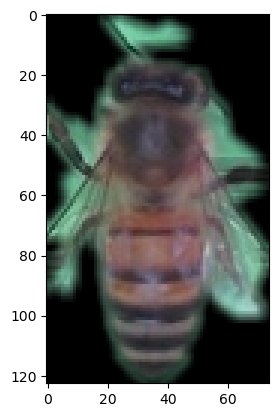

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'warpAffine'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [48]:

colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
img_num = np.random.randint(0, 5242)
ds_entry = list(dataset[0])[img_num]
image = np.array(ds_entry[0])
label = tfds.as_numpy(ds_entry[1].values())
trans_label = []
j = 1
while j <= len(label):
    trans_label.append(label[j-1]*j)
    j = j + 1
trans_label = np.array(int(np.sum(trans_label)))
label = trans_label

print(label)
plt.imshow(new_image)
plt.show()

new_image = extract_sub(image)
image, new_coords = process_image(new_image)
image = tf.expand_dims(tf.squeeze(image), axis=0)
new_coords = tf.reshape(tf.cast(new_coords, tf.float32),[1, 1, 4])

print((tf.one_hot(trans_label, 5), new_coords))
plt.imshow(image)
plt.show()

def read_image_tfds(image, label):
    
    new_image = extract_sub(image)
    image, new_coords = process_image(new_image)
    image = tf.expand_dims(tf.squeeze(image), axis=0)
    new_coords = tf.reshape(tf.cast(new_coords, tf.float32),[1, 1, 4])
    return image, (tf.one_hot(trans_label, 5), new_coords)


image, label = read_image_tfds(new_image, label)
image = tf.image.draw_bounding_boxes(image, label[1], colors)

# One hot ['normal' 'cooling', 'pollen', 'varroa', 'wasps']

plt.imshow(tf.squeeze(image))
plt.show()


print("Done")

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

## Selecting Strategy

In [11]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


### Parameters

The global batch size is the batch size per replica (64 in this case) times the number of replicas in the distribution strategy.

In [12]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Global batch size.
# The global batch size will be automatically shared across all
# replicas by the tf.data.Dataset API. The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.
print("Done")

Done


In [26]:
'''
Loads and maps the training split of the dataset using the map function.
'''

def get_training_dataset():
    with  strategy.scope():
        dataset = tfds.load("bee_dataset/bee_dataset_150", split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"], as_supervised=True)
        dataset = dataset[0].map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

'''
Loads and maps the validation split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''  
def get_validation_dataset():
    dataset = tfds.load("bee_dataset/bee_dataset_150", split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"], as_supervised=True)
    dataset = dataset[1].map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

print("Done")

NotImplementedError: in user code:

    File "C:\Users\khard\AppData\Local\Temp\ipykernel_40388\2950430053.py", line 18, in read_image_tfds  *
        new_image = extract_sub(image)
    File "C:\Users\khard\AppData\Local\Temp\ipykernel_40388\1280476086.py", line 5, in extract_sub  *
        new_image = np.array(new_image)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [312]:
# By convention, our non-background classes start counting at 1.
num_classes = 5

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

NameError: name 'train_images_np' is not defined

# Let's just visualize the bees as a sanity check


In [ ]:
dummy_scores2 = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx-1],
      gt_boxes[idx-1],
      np.ones(shape=[gt_boxes[idx-1].shape[0]], dtype=np.int32),
      dummy_scores2, category_index)
plt.show()

print(train_images_np[0])
print(gt_boxes[0])
print(np.ones(shape=[gt_boxes[0].shape[0]], dtype=np.int32))
print(dummy_scores2)
print(category_index)
print(type(train_images_np[0]))
print(type(gt_boxes[0]))
print(type(np.ones(shape=[gt_boxes[0].shape[0]], dtype=np.int32)))
print(type(dummy_scores2))
print(type(category_index))

NameError: name 'train_images_np' is not defined

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [1]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 5
pipeline_config = '/home/kevinhardin/Documents/Tensorflow/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/home/kevinhardin/Documents/Tensorflow/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

NameError: name 'tf' is not defined

# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  #@tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


# Load test images and run inference with new model!

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, comment this decorator if you want to run inference eagerly
#@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))